# Load model pytorch only


In [1]:
# bizarre error, the order of imports matters here. If DefaultPredictor isn't imported after numpy, etc. then kenrel restarts
import os
import skimage.io as skio
from skimage import img_as_ubyte, exposure
from PIL import Image as pilimg
import warnings
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine.defaults import DefaultPredictor

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
cfg = get_cfg()    # obtain detectron2's default config
cfg.CONFIG_NAME = '' # add new configs for your own custom components
cfg.DATASET_PATH = ''
cfg_path = os.path.join("../app/most-recent-best-model-and-config-dec-2020/config.yaml")
cfg.merge_from_file(cfg_path)   # load values from a file
cfg.MODEL.WEIGHTS = "../app/most-recent-best-model-and-config-dec-2020/model_0002799.pth"
# model = build_model(cfg)  # returns a torch.nn.Module
# loaded_m = DetectionCheckpointer(model).load(model_path) 

cfg.INPUT.MIN_SIZE_TEST = 800
cfg.INPUT.MAX_SIZE_TEST = 1333

In [3]:
def read_and_rescale_tif(img_tile, clamp_low=262, clamp_high=1775): # Landsat 5 ARD .25 and 97.75 percentile range for Nebraska
    img_array = skio.imread(img_tile)
    img_array = exposure.rescale_intensity(img_array, in_range=(clamp_low, clamp_high))  # Landsat 5 ARD .25 and 97.75 percentile range.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img_array = img_as_ubyte(img_array)
    return img_array

def save_rescaled_jpeg(old_tif_path, jpeg_dir, rescaled_arr):
    img_pil = pilimg.fromarray(rescaled_arr)
    fid = os.path.basename(old_tif_path).split(".tif")[0]
    jpeg_path = os.path.join(jpeg_dir, fid + ".jpg")
    # Export chip images
    with open(Path(jpeg_path), 'w') as dst:
        img_pil.save(dst, format='JPEG', subsampling=0, quality=100)

In [4]:
arr = skio.imread("../images/aoi_restricted_LT05_CU_015008_20050830_20190107_C01_V0_-300225_2018565.jpg")

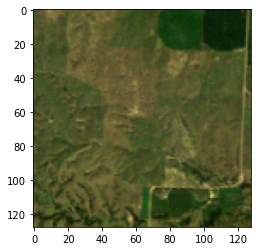

In [5]:
import matplotlib.pyplot as plt
plt.imshow(arr[:,:,::-1])

In [6]:
pred = DefaultPredictor(cfg)
result = pred(arr[:,:,::-1])

In [7]:
import torch
from torch.utils.cpp_extension import CUDA_HOME
print(torch.cuda.is_available(), CUDA_HOME)

True /usr/local/cuda


/usr/local/envs/ai4e_py_api/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


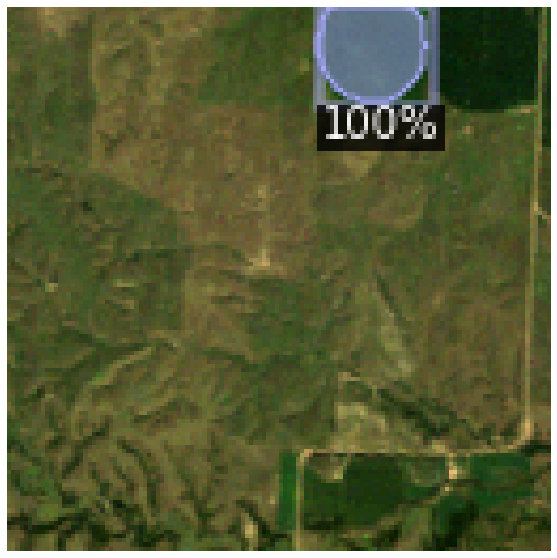

In [9]:
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
metadata = MetadataCatalog.get("test")
vis_p = Visualizer(arr[:,:,::-1], metadata, instance_mode=ColorMode.SEGMENTATION)

# move to cpu
instances = result['instances']
instances.pred_boxes.tensor = instances.pred_boxes.tensor.cpu()
instances.scores = instances.scores.cpu()
instances.pred_classes = instances.pred_classes.cpu()
instances.pred_masks = instances.pred_masks.cpu()

import torch

import copy

single = copy.deepcopy(instances)
single.pred_boxes.tensor = single.pred_boxes.tensor[0].unsqueeze(0)
single.scores = single.scores[0].unsqueeze(0)
single.pred_classes = single.pred_classes[0].unsqueeze(0)
single.pred_masks = torch.tensor(single.pred_masks[0]).unsqueeze(0)

vis_pred_im = vis_p.draw_instance_predictions(single).get_image()

def show_im(image, ax):
    # Show area outside image boundaries.
    ax.axis('off')
    ax.imshow(image)
    return ax

plt.rcParams['font.size'] = 20
plt.rcParams['axes.linewidth'] = 2
plt.style.use("seaborn")
fig,ax = plt.subplots(figsize=(10,10))
show_im(vis_pred_im,ax)

In [10]:
import detectron2
detectron2.__version__

'0.1.2'

In [11]:
import torch
torch.__version__

'1.5.1'

In [12]:
import torchvision
torchvision.__version__

'0.6.0a0+35d732a'